# Оптимизатор Lion

Не Adam-ом единым живут нейронные сети. Есть альтернативные методы оптимизации. Например, проект [Google Brain](https://research.google/teams/brain/) в 2023 году опубликовал [статью](https://arxiv.org/pdf/2302.06675.pdf), в которой описывает найденный в процессе [AutoML](https://arxiv.org/pdf/2101.08809.pdf) (автоматического подбора архитектур и алгоритмов) оптимизатор, названный **Lion**  (Evo**L**ved S**i**gn M**o**me**n**tum) 🦁.

Интересно, что AutoML-алгоритм пришел к интуитивно понятной эвристике: градиенты — вещь не очень надежная. Они могут взрываться и затухать. Может тогда мы зафиксируем размер шага, а градиенты будем использовать только для определения направления? 

Для определения направления используют функцию $sign$ (знак):

\begin{align}
\text{sign}(x) = \left\{
\begin{array}{cl}
1 & x > 0 \\
0 & x = 0\\
-1 & x < 0.
\end{array}
\right.
\end{align}


К этому добавляется уже знакомый нам [momentum](https://edunet.kea.su/repo/msu_ai/html/L07_Batch_normalization.html#Momentum), чтобы знак “прыгал” реже. Интересно, что AutoML подобрал алгоритм, в котором используются две константы для momentum: $\beta_1$ — для определения текущего знака градиента, $\beta_2$ — для хранения значения $v_t$. Значения по умолчанию $\beta_1 = 0.9$, $\beta_2 = 0.99$. Это значит, что текущее значение градиента сильнее влияет на значение для выбора направления текущего шага $с_{t}$, чем на хранимое значение момента $v_t$.


Значение для вычисления текущего шага:
$$с_{t} = \beta_1 \cdot v_{t-1} + (1-\beta_1) \nabla_wL(x, y, w_{t})$$

Шаг оптимизатора. $λ$ — константа weight decay:
$$w_{t+1} = w_t - lr \cdot (sign(c_t) +λ w_t)$$

Обновление хранимого значения момента:


$$v_t = \beta_2 \cdot v_{t-1} + (1-\beta_2) \nabla_wL(x, y, w_{t})$$

Фрагмент кода для понимания работы Lion (этот код не нужно использовать в проекте, он приведен для улучшения понимания формул):

```
class Lion:  
  def __init__(self, parameters, lr=0.0001, betas=(0.9, 0.99), weight_decay=0.01):
    self.parameters = parameters
    self.lr = lr
    self.betas = betas
    self.velocity = torch.zeros_like(parameters) 
    self.beta_1 = betas[0] # momentum 1 
    self.beta_2 = betas[1] # momentum 2
    self.weight_decay = weight_decay
  
  def step(self):
    d_parameters = self.parameters.grad
    # current momentum
    current = self.beta_1*self.velocity + (1-self.beta_1)*d_parameters
    # step
    self.parameters -= self.lr * (torch.sign(current) + self.weight_decay*self.parameters)
    # history momentum
    self.velocity = self.beta_2*self.velocity + (1 - self.beta_2)*d_parameters
```

Обратите внимание, что значение lr по умолчанию у Lion выбрано меньше, чем у Adam. Это связано с тем, что только lr и регуляризация определяют размер шага. Авторы статьи советуют брать для Lion в 10 раз меньший lr, чем для Adam.

У Lion есть преимущества по сравнению с Adam и AdamW. В нем нет необходимости хранить квадраты градиентов. Он позволяет **снизить количество хранимых параметров** в 1.5–2 раза по сравнению с AdamW, а также сокращает количество операций, что позволяет [ускорить расчеты на 2-15%](https://arxiv.org/pdf/2302.06675.pdf) (в colab это незаметно из-за специфики, связанной с виртуальными машинами). 

Кроме того, Lion [позволяет добиться лучших результатов](https://github.com/google/automl/tree/master/lion), чем AdamW, при обучении больших сложных моделей, таких как Visual Transformer-ы и диффузионные модели.

Мы попробуем Lion на простой модели, взятой из [лекции 7](https://edunet.kea.su/repo/msu_ai/html/L07_Batch_normalization.html). 

Lion не входит в ядро PyTorch (туда добавляют новые блоки только после длительной апробации). Воспользуемся реализацией [lion-pytorch](https://github.com/lucidrains/lion-pytorch). Он не входит в список предустановленных в colab пакетов, поэтому установим.

In [ ]:
!pip install lion-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Экспериментировать будем с датасетом [MNIST](http://yann.lecun.com/exdb/mnist/) (датасет рукописных цифр). 

In [ ]:
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# transforms for data
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.13), (0.3))]
)

train_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


Добавим код для визуализации. 

Код для сглаживания графиков

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

Класс для визуализации

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


class HistoryPlotter:
    def __init__(self):
        # dict for save learning history
        self._history_dict = {}
    
    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epohs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True ,smooth_val=0.90):
        """
        Plot information from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(6, 12))
        plt.subplots_adjust(hspace=0.3)
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], 
                    ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epochs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epochs"]+1)

                if show_smooth:
                    x = np.arange(len(history[key]))/epoch_len
                    # Plot train loss and test loss:
                    # 1. plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name+" smoothed",
                        color=self.color_list[2*model_num+idx],
                    )
                    # 2. plot raw vals
                    ax[idx].plot(
                        x,
                        history[key], 
                        label=model_name+" raw", 
                        alpha=0.2, 
                        color=self.color_list[2*model_num+idx],
                    )
                    # 3. add descriptions if it is necessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epochs"]+1))
                    ax[idx].legend()
                
                # Plot mean train and test loss combined:
                # 1. calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. plot
                ax[2].errorbar(
                    np.arange(history["epochs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name+" "+title,
                )
                # 3. add descriptions if it is necessary
                if not ax[idx].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch")
                    ax[2].set_xticks(np.arange(history["epochs"]))
                    ax[2].set_xticklabels(np.arange(history["epochs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        
        plt.show()    

In [ ]:
history_plotter = HistoryPlotter()

Код модели: простая учебная fully connected нейронная сеть из [лекции 7](https://edunet.kea.su/repo/msu_ai/html/L07_Batch_normalization.html) и [Batch normalization](https://edunet.kea.su/repo/msu_ai/html/L07_Batch_normalization.html#Batch-Normalization) между слоями.

In [ ]:
from torch import nn as nn

class SimpleMNIST_NN_Init_Batchnorm(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.n_layers = n_layers
        layers = [
            nn.Linear(28 * 28, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
        ]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100, bias=False))
            layers.append(nn.BatchNorm1d(100))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)
        self.init()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("sigmoid")
        for child in self.layers.children():
            if isinstance(child, nn.Linear):
                torch.nn.init.xavier_normal_(child.weight, gain=sigmoid_gain)
                if child.bias is not None:
                    torch.nn.init.zeros_(child.bias)

Одна эпоха обучения 

In [ ]:
import torch

# compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_epoch(model, optimizer, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().item())  # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

Код для валидации

In [ ]:
def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().item())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history

Код для обучения

In [ ]:
from tqdm import tqdm


def train_model_sep(model, optimizer, model_name=None, num_epochs=5):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epochs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        model.eval()
        _, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
    return train_history

Для сравнения попробуем обучить модель с оптимизатором [Adam](https://edunet.kea.su/repo/msu_ai/html/L07_Batch_normalization.html#Adam) без регуляризации

In [ ]:
import torch.optim as optim
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

model_name = "adam"
history = train_model_sep(model, optimizer, model_name="adam", num_epochs=5)

100%|██████████| 5/5 [02:03<00:00, 24.63s/it]


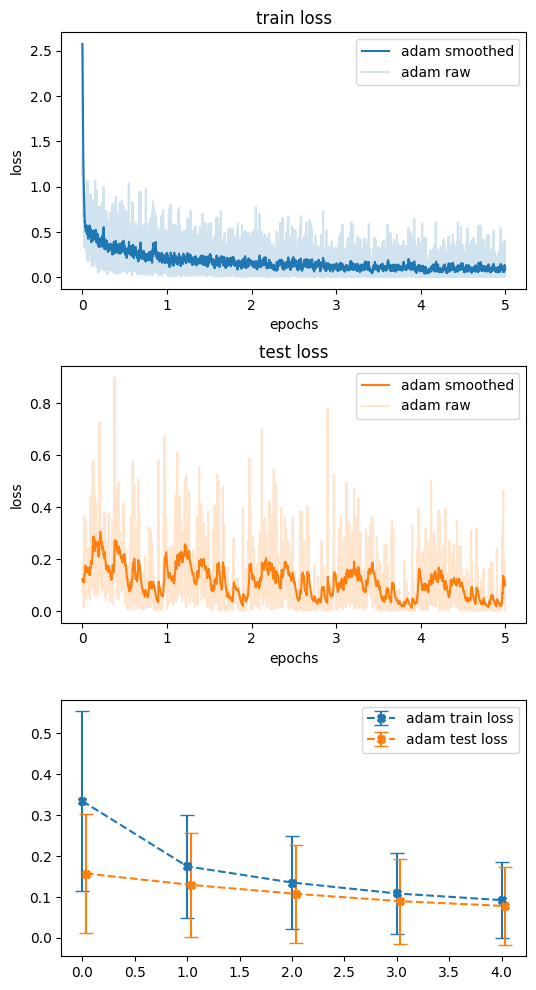

In [ ]:
history_plotter.add(history)
history_plotter.plot([model_name])

Модель с оптимизатором Adam c [Weight decay](https://edunet.kea.su/repo/msu_ai/html/L07_Batch_normalization.html#L2-vs-Weight-decay)

In [ ]:
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=0.001)

model_name = "adamw"
history = train_model_sep(model, optimizer, model_name="adamw", num_epochs=5)

100%|██████████| 5/5 [01:58<00:00, 23.76s/it]


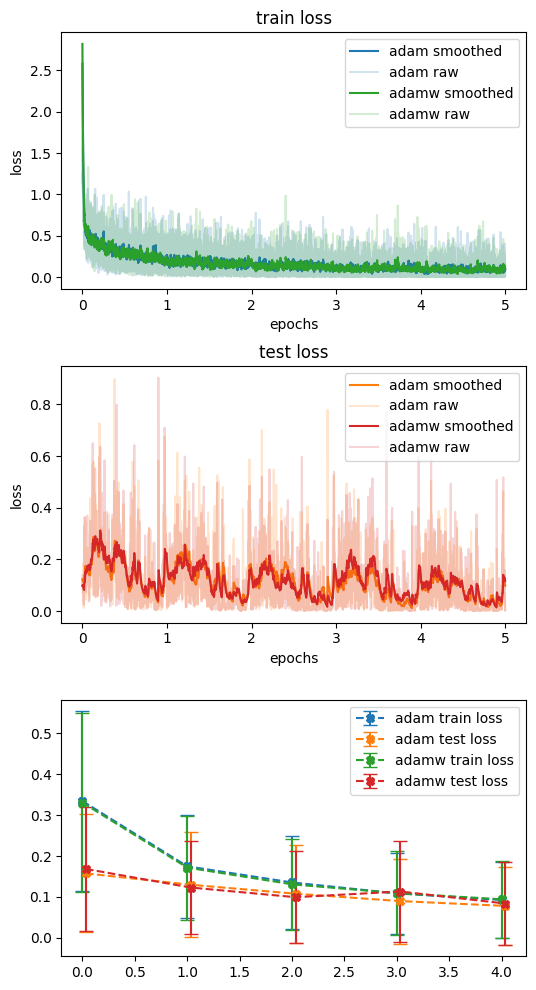

In [ ]:
history_plotter.add(history)
history_plotter.plot(["adam", model_name])

А теперь с оптимизатором Lion.

In [ ]:
from lion_pytorch import Lion

model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-3)

model_name = "lion"
history = train_model_sep(model, optimizer, model_name="lion", num_epochs=5)

100%|██████████| 5/5 [01:56<00:00, 23.36s/it]


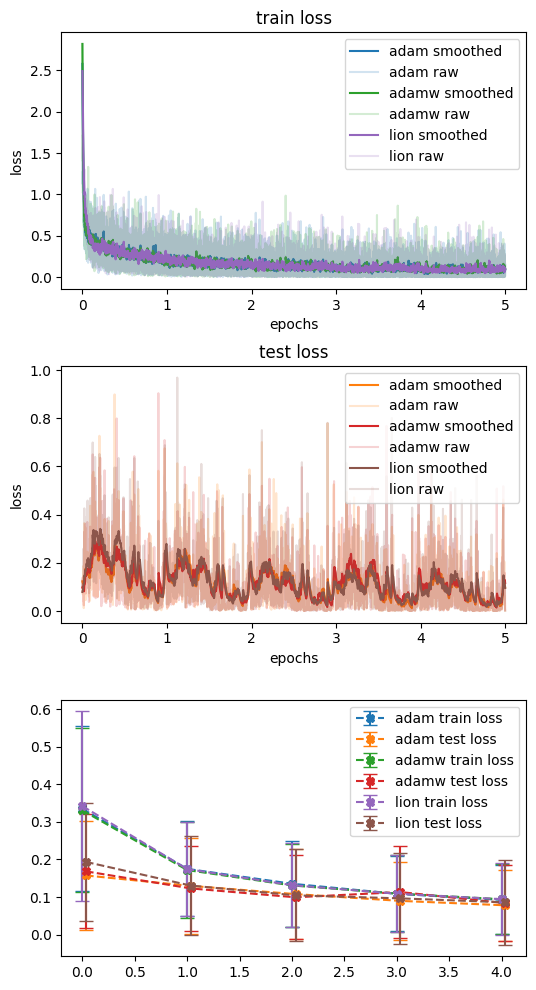

In [ ]:
history_plotter.add(history)
history_plotter.plot(["adam", "adamw", model_name])

Результат получился примерно как у Adam, число хранимых параметров меньше. 

Имеет смысл пробовать оптимизатор Lion, особенно для больших моделей. Но будьте осторожны: алгоритм свежий и может быть не до конца отработан. 